<a href="https://colab.research.google.com/github/bhaghighi/AG-CNN/blob/master/lstm_attention/Learning_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
from torchvision import models
from torchsummary import summary

import torch
import torch.nn as nn
from torch.autograd import Variable

In [75]:
!pip install torchviz

In [76]:
!pip install torchview

torch.Size([98, 2, 1]) torch.Size([98, 1])
input_shape torch.Size([98, 2, 1]) ('output_shape', torch.Size([98, 1]))
after lstm torch.Size([98, 2, 100])
after atten shape torch.Size([98, 2, 100])
getting atten last torch.Size([98, 100])
after fully connected torch.Size([98, 1]) output
after lstm torch.Size([98, 2, 100])
after atten shape torch.Size([98, 2, 100])
getting atten last torch.Size([98, 100])
after fully connected torch.Size([98, 1]) output
after lstm torch.Size([98, 2, 100])
after atten shape torch.Size([98, 2, 100])
getting atten last torch.Size([98, 100])
after fully connected torch.Size([98, 1]) output
after lstm torch.Size([98, 2, 100])
after atten shape torch.Size([98, 2, 100])
getting atten last torch.Size([98, 100])
after fully connected torch.Size([98, 1]) output
after lstm torch.Size([98, 2, 100])
after atten shape torch.Size([98, 2, 100])
getting atten last torch.Size([98, 100])
after fully connected torch.Size([98, 1]) output
after lstm torch.Size([98, 2, 100])
aft

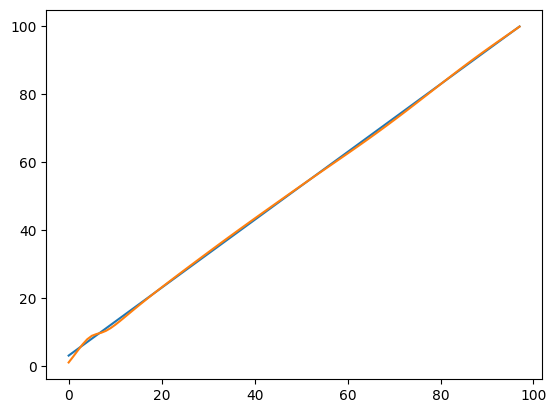

In [78]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# creating simple data set

sdata = np.array([i for i in range(1,101)]).reshape(-1,1)

def DataSet(X, look_back=2, p=False):
  Train= list()
  Test = list()
  for i in range(len(X) - look_back):
    X_train = X[i: (i + look_back)]
    X_test = X[i + look_back]
    Train.append(X_train)
    Test.append(X_test)
    if p:
      print (X_train, "--->", X_test)
  return np.stack(Train), np.vstack(Test)



X_train, y_train = DataSet(sdata, look_back=2)
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
print (X_train.shape, (y_train.shape))


#
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
    super(LSTM, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.output_dim = output_dim

    self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)
    self.fc = nn.Linear(self.hidden_dim, output_dim)

  def forward(self, x):
    out, _ = self.lstm(x)
    print (out.shape)
    # getting last value for sequence
    out = out[:,-1,:]
    out = self.fc(out)
    return out

# SelfAttention class
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention_weights = self.softmax(scores)
        weighted_sum = torch.bmm(attention_weights, values)
        return attention_weights, weighted_sum

# class SelfAttention with LSTM
class LSTMWithAttention(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim,num_layers):
    super(LSTMWithAttention, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.output_dim = output_dim

    # defining layers
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
    self.attention = SelfAttention(hidden_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    lstm_out, _ = self.lstm(x)
    print ("after lstm",lstm_out.shape)
    #
    atten_weights, atten = self.attention(lstm_out)
    print ("after atten shape", atten.shape)
    #
    atten_last = atten[:, -1, :]
    print ("getting atten last", atten_last.shape)
    #
    output = self.fc(atten_last)
    print  ("after fully connected", output.shape, "output")
    return output


print ("input_shape",X_train.shape, ("output_shape",y_train.shape))
input_dim = X_train.shape[2]
hidden_dim = 100
num_layers = 1
output_dim = 1
#
lr = 0.01
epochs = 50

'''lstm = LSTM(input_dim, hidden_dim, output_dim, num_layers)
out = lstm(X_train)
print ("out", out.shape)'''

model = LSTMWithAttention(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train.squeeze())

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plot the original data and the predicted values after training
with torch.no_grad():
    model.eval()
    predicted = model(X_train).squeeze()


plt.plot(y_train.squeeze())
plt.plot(predicted)

Input Sequence Shape: torch.Size([90, 10])
Target Shape: torch.Size([90])
torch.Size([90, 10, 32]) lstm_out
torch.Size([90, 10, 10]) torch.Size([90, 10, 32]) attention
torch.Size([90, 32]) attended_last
torch.Size([90, 1]) output
torch.Size([90, 10, 32]) lstm_out
torch.Size([90, 10, 10]) torch.Size([90, 10, 32]) attention
torch.Size([90, 32]) attended_last
torch.Size([90, 1]) output
torch.Size([90, 10, 32]) lstm_out
torch.Size([90, 10, 10]) torch.Size([90, 10, 32]) attention
torch.Size([90, 32]) attended_last
torch.Size([90, 1]) output
torch.Size([90, 10, 32]) lstm_out
torch.Size([90, 10, 10]) torch.Size([90, 10, 32]) attention
torch.Size([90, 32]) attended_last
torch.Size([90, 1]) output
torch.Size([90, 10, 32]) lstm_out
torch.Size([90, 10, 10]) torch.Size([90, 10, 32]) attention
torch.Size([90, 32]) attended_last
torch.Size([90, 1]) output
torch.Size([90, 10, 32]) lstm_out
torch.Size([90, 10, 10]) torch.Size([90, 10, 32]) attention
torch.Size([90, 32]) attended_last
torch.Size([90, 1

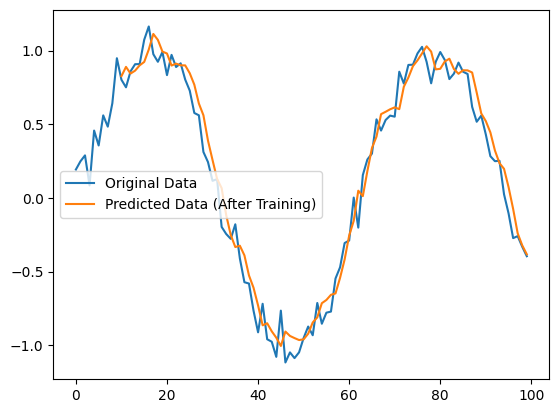

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Synthetic time series data
torch.manual_seed(42)
time_steps = torch.arange(0, 100, 1)
data = torch.sin(0.1 * time_steps) + 0.1 * torch.randn(100)

# Function to create input sequences and targets
def create_sequences_and_targets(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return torch.stack(sequences), torch.stack(targets)

# Define the SelfAttention class
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention_weights = self.softmax(scores)
        weighted_sum = torch.bmm(attention_weights, values)
        return attention_weights, weighted_sum

# Define the model with LSTM and self-attention (without concatenation)
class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.attention = SelfAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # Apply LSTM
        lstm_out, _ = self.lstm(x)
        print (lstm_out.shape, "lstm_out")

        # Apply self-attention
        attention_weights, attended = self.attention(lstm_out)
        print (attention_weights.shape, attended.shape, "attention")

        # Take the output of the last time step (attended output)
        attended_last = attended[:, -1, :]
        print (attended_last.shape, "attended_last")

        # Fully connected layer
        output = self.fc(attended_last)
        print  (output.shape, "output")

        return output

# Hyperparameters
input_dim = 1
hidden_dim = 32
seq_length = 10
lr = 0.01
epochs = 50

# Create sequences and targets
sequences, targets = create_sequences_and_targets(data, seq_length)

# Print the shape of input sequence and target
print(f"Input Sequence Shape: {sequences.shape}")
print(f"Target Shape: {targets.shape}")

# Instantiate the model, loss, and optimizer
model = LSTMWithAttention(input_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    # Forward pass
    outputs = model(sequences.unsqueeze(2))
    loss = criterion(outputs.squeeze(), targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plot the original data and the predicted values after training
with torch.no_grad():
    model.eval()
    predicted = model(sequences.unsqueeze(2)).squeeze()

plt.plot(time_steps, data, label='Original Data')
plt.plot(time_steps[seq_length:], predicted.detach().numpy(), label='Predicted Data (After Training)')
plt.legend()
plt.show()


In [ ]:
'''
Input Sequence
(batch_size, seq_length, input_dim)
   |
   v

  LSTM
(batch_size, seq_length, hidden_dim)
   |
   v

Attention
(batch_size, seq_length, hidden_dim)
   |
   v

 Fully Connected
(batch_size, output_dim)
'''